# MLNS Final Project: Into the Networks of Life
------------------------------------------------------------
### Authors: Dwivedi Deepesh, Giacopelli Nicolò, Liu Dayu, Remadi Adel

# Graph Classification - PROTEINS

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# Imports (on Collab)

!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install torch_geometric  --quiet


import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y  --quiet
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html  --quiet
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html  --quiet
!pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet


import os
import torch
import dgl
import torch_geometric
import numpy as np
import seaborn as sns
from functions import *
from models import *

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 48.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 49.4 MB/s eta 0:

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
# Global variables


PATH_IMG = "drive/MyDrive/MLNS/images"
PATH_MODELS = "drive/MyDrive/MLNS/models"

TRAIN_RATIO, VAL_RATIO = 0.7, 0.15


# Global

fmt = '%.2f%%' 
yticks = mtick.FormatStrFormatter(fmt)

SEED = 42

generator = torch.Generator().manual_seed(SEED)
torch.manual_seed(SEED)



## DGL loading

In [ ]:

# Fix seed
set_reproducible()


# Get Loaders

train_batch_size, val_batch_size, test_batch_size = 5, 5, 1


dataset = dgl.data.TUDataset(name='PROTEINS', transform=dgl.add_self_loop)

max_nodes = dataset.max_num_node

print('\nNumber of graph categories:', dataset.num_labels)
print('Maximum number of nodes:', dataset.max_num_node)
print('Dimension of nodes features', dataset[0][0].ndata['node_attr'].shape[1])

train_loader, val_loader, test_loader = get_dgl_loaders(dataset, TRAIN_RATIO, VAL_RATIO, train_batch_size, val_batch_size, test_batch_size, generator)




Number of graph categories: 2
Maximum number of nodes: 620
Dimension of nodes features 1

Length training set 779, Length validation set 166, Length test set 168


In [ ]:

from dgl.nn import GraphConv


class GraphConvModel(torch.nn.Module):
    """
    Base model to perform aggregation of latent variables either by mean or by max
    """

    def __init__(self, n_layers, input_size, hidden_size, output_size, agg):
        super(GraphConvModel, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)
        self.agg = dgl.mean_nodes if agg=="mean" else dgl.max_nodes

    def forward(self, g, x):
        # Message Passing
        for conv in self.convs[:-1]:
            x = F.elu(conv(g, x))
        x = self.convs[-1](g, x)
        # Readout 
        g.ndata['h'] = x
        x = self.agg(g, 'h')
        x = self.linear(x)
        return x


# Mean as readout

In [ ]:


n_features, n_classes = dataset[0][0].ndata['node_attr'].shape[1], dataset.num_labels


num_epochs = 200
hidden_size = 128
layers = 5
agg = "mean"
wd = 0.01
lr = 2e-4

device = "cuda" if torch.cuda.is_available() else "cpu"


# Define model, loss function and optimizer
model = GraphConvModel(layers, n_features, hidden_size, n_classes, agg).to(device)


optim = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True, weight_decay = wd)
loss_fcn = torch.nn.CrossEntropyLoss()

patience, delta = 15, 0
early_stopper_mean = EarlyStopping(patience, delta, path=PATH_MODELS)




# Train and Valid
mean_tr_loss, mean_tr_acc, mean_val_loss, mean_val_acc = train(model, loss_fcn, optim, train_loader, val_loader, 
                                                       num_epochs, early_stopper_mean, device, save = "model_mean", scheduler=None)



Epoch 0/200 | Train Loss: 0.6759 | Train Accuracy: 60.4487% | Val Loss: 0.6574 | Val Accuracy 62.3529%
Epoch 10/200 | Train Loss: 0.6497 | Train Accuracy: 64.6795% | Val Loss: 0.6562 | Val Accuracy 62.9412%
Epoch 20/200 | Train Loss: 0.6419 | Train Accuracy: 65.0641% | Val Loss: 0.6570 | Val Accuracy 62.9412%
Epoch 30/200 | Train Loss: 0.5819 | Train Accuracy: 70.3526% | Val Loss: 0.6098 | Val Accuracy 68.2353%
Epoch 40/200 | Train Loss: 0.5516 | Train Accuracy: 72.8205% | Val Loss: 0.6584 | Val Accuracy 67.6471%
Early Stopping!



Test Loss: 0.6324 | F1 score: 0.4330 | Test Accuracy 67.2619%



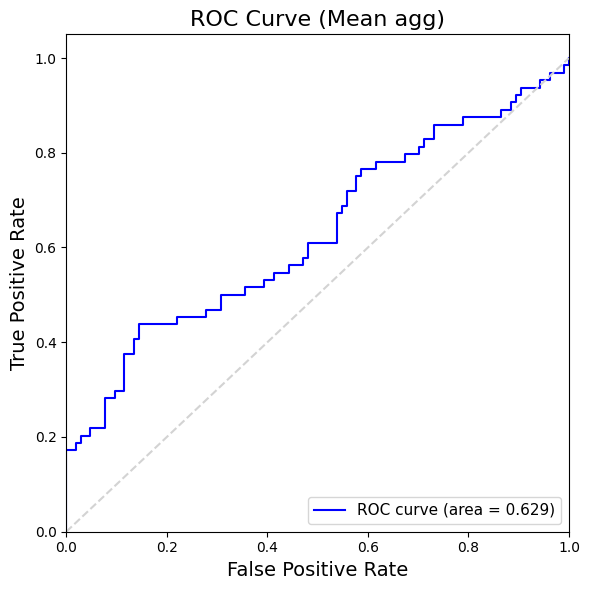

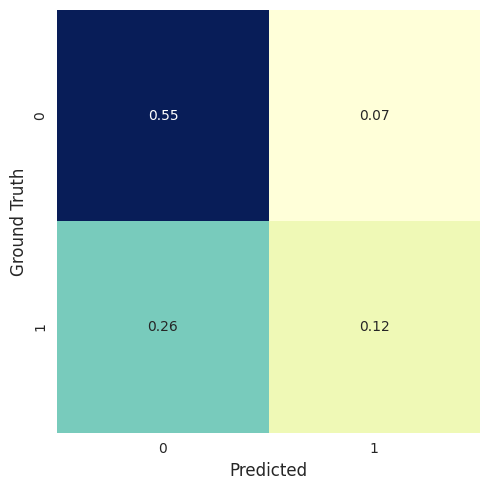

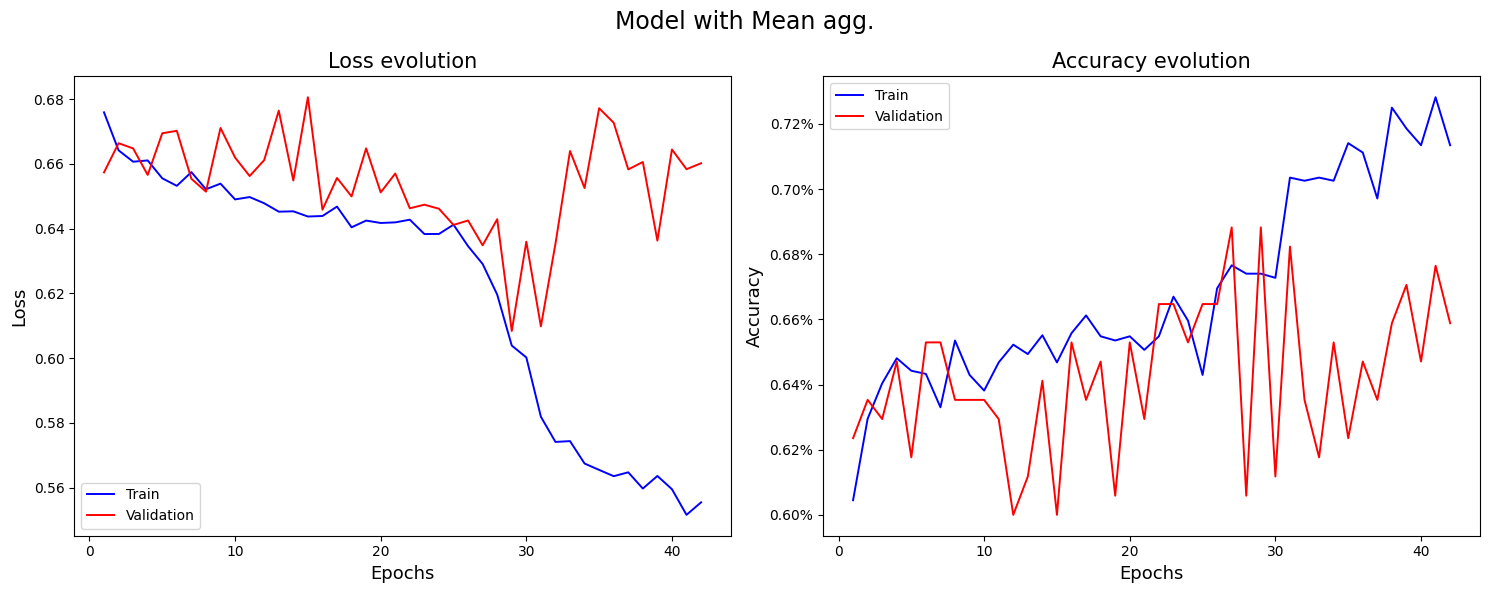

In [ ]:

# Test


# For storing
name_vis = "Model with Mean agg."
name_save = "mean_agg"



# Reloading best model
best_model = early_stopper_mean.best_model.to(device)

# Evaluation
mean_test_loss, mean_test_acc, mean_confusion_matrix = test(best_model, loss_fcn, test_loader, device, cm=True, title="Mean agg", c="blue",  path=PATH_IMG, name_save=name_save + "_roc")


# Plots
history_mean = [[mean_tr_loss, mean_val_loss], [mean_tr_acc, mean_val_acc]]


plot_confusion_matrix(mean_confusion_matrix, PATH_IMG, name_save=name_save + "_cm")

plot_results(history_mean, name_vis, yticks, PATH_IMG, name_save=name_save + "_results")





# Max as readout

In [ ]:


num_epochs = 200
hidden_size = 128
layers = 5
agg = "max"
wd = 0.01
lr = 2e-4



# Define model, loss function and optimizer
model = GraphConvModel(layers, n_features, hidden_size, n_classes, agg)


optim = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True, weight_decay = wd)
loss_fcn = torch.nn.CrossEntropyLoss()

patience, delta = 15, 0
early_stopper_max = EarlyStopping(patience, delta, path=PATH_MODELS)
device = "cuda" if torch.cuda.is_available() else "cpu"

schedul = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)


# Train and Valid
max_tr_loss, max_tr_acc, max_val_loss, max_val_acc = train(model, loss_fcn, optim, train_loader, val_loader, 
                                                       num_epochs, early_stopper_max, device, save = "model_max", scheduler=None)



Epoch 0/200 | Train Loss: 0.6611 | Train Accuracy: 61.0897% | Val Loss: 0.6210 | Val Accuracy 65.8824%
Epoch 10/200 | Train Loss: 0.5432 | Train Accuracy: 73.0769% | Val Loss: 0.5560 | Val Accuracy 71.7647%
Epoch 20/200 | Train Loss: 0.4720 | Train Accuracy: 76.5064% | Val Loss: 0.5584 | Val Accuracy 75.8824%
Epoch 30/200 | Train Loss: 0.3843 | Train Accuracy: 80.7692% | Val Loss: 0.7445 | Val Accuracy 70.0000%
Early Stopping!



Test Loss: 0.4943 | F1 score: 0.6306 | Test Accuracy 75.5952%



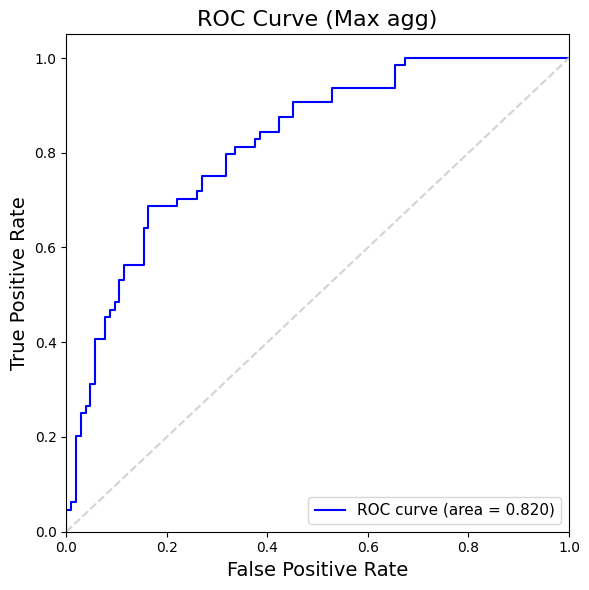

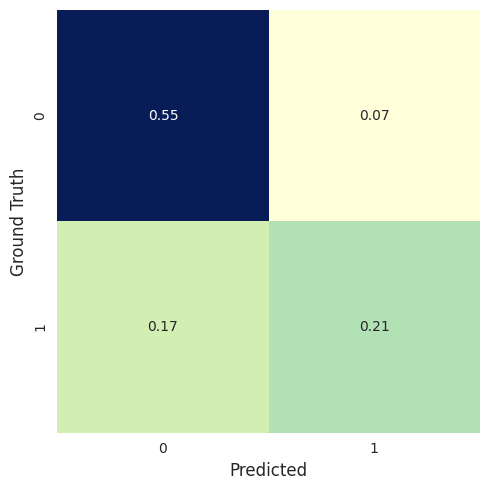

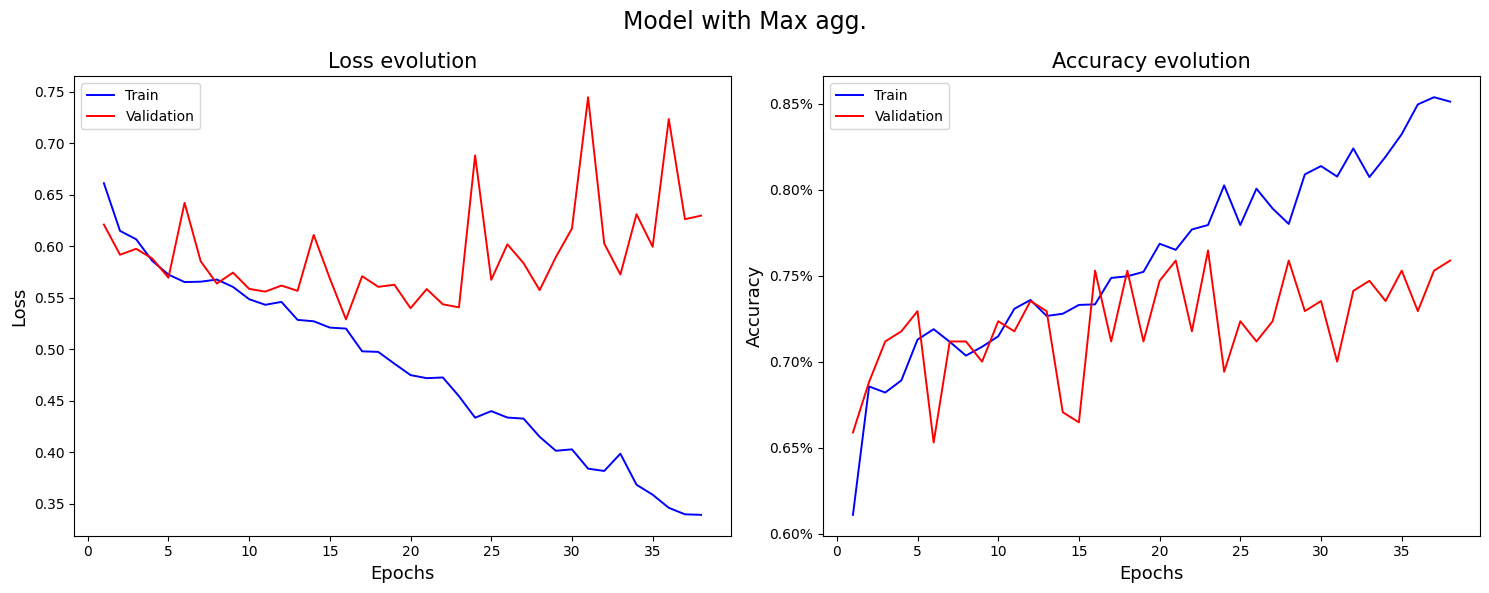

In [ ]:

# Test


# For storing

name_vis = "Model with Max agg."
name_save = "max_agg"


# Reloading best model
best_model = early_stopper_max.best_model.to(device)

# Evaluation
max_test_loss, max_test_acc, max_confusion_matrix = test(best_model, loss_fcn, test_loader, device, cm=True, title="Max agg", c="blue",  path=PATH_IMG, name_save=name_save + "_roc")



# Plots
history_max = [[max_tr_loss, max_val_loss], [max_tr_acc, max_val_acc]]


plot_confusion_matrix(max_confusion_matrix, PATH_IMG, name_save=name_save + "_cm")

plot_results(history_max, name_vis, yticks, PATH_IMG, name_save=name_save + "_results")





## Torch Loading (dense)

In [ ]:


# Fix seed
set_reproducible()



class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes

dataset = torch_geometric.datasets.TUDataset(root=f'./data', name='PROTEINS', transform=T.Compose([AddSelfLoops(), T.ToDense(max_nodes)]),
                                                                                        pre_filter=MyFilter())



# Get Loaders
train_batch_size, val_batch_size, test_batch_size = 5, 5, 1


train_loader, val_loader, test_loader = get_torch_loaders(dataset, TRAIN_RATIO, VAL_RATIO, train_batch_size, val_batch_size, test_batch_size, generator, dense=True)





Length training set 779, Length validation set 166, Length test set 168


# Diff Pool

In [ ]:


from math import ceil
from models import GNN
from torch_geometric.nn import dense_diff_pool


class DiffPool(torch.nn.Module):
    """
    Model implementing DiffPool architecture, composed of alternating Message Passing and Pooling layers
    with soft cluster assignments predicted by a MLP
    """
    def __init__(self, max_nodes, in_channels=3, hidden_size=64, out_channels=2):
        super(DiffPool, self).__init__()

        num_nodes = ceil(0.25 * max_nodes)
        self.gnn1_pool = GNN(in_channels, hidden_size, num_nodes)
        self.gnn1_embed = GNN(in_channels, hidden_size, hidden_size)

        num_nodes = ceil(0.25 * num_nodes)
        self.gnn2_pool = GNN(hidden_size, hidden_size, num_nodes)
        self.gnn2_embed = GNN(hidden_size, hidden_size, hidden_size)

        self.gnn3_embed = GNN(hidden_size, hidden_size, hidden_size)

        self.lin1 = torch.nn.Linear(hidden_size, hidden_size)
        self.lin2 = torch.nn.Linear(hidden_size, out_channels)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)

        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        x = self.gnn3_embed(x, adj)

        x = x.mean(dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2


In [ ]:

# Diff Pool


# Define model, loss function and optimizer

in_chann = dataset.num_features
out_chann = dataset.num_classes
hidd_size = 128

model = DiffPool(max_nodes, in_channels=in_chann, hidden_size=hidd_size, out_channels=out_chann).to(device)


num_epochs = 200
wd = 0.01
lr = 2e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True, weight_decay = wd)

loss_fcn = torch.nn.NLLLoss()

patience, delta = 18, 0
early_stopper_diff = EarlyStopping(patience, delta, path=PATH_MODELS)


# Train and Valid

diff_tr_loss, diff_tr_acc, diff_val_loss, diff_val_acc = train_dense(model, loss_fcn, optim, train_loader, val_loader, num_epochs, 
                                                               early_stopper_diff, device, save="model_diffpool", scheduler=None)



Epoch 0/200 | Train Loss: 0.6379 | Train Accuracy: 63.4615% | Val Loss: 0.5482 | Val Accuracy 78.8235%
Epoch 10/200 | Train Loss: 0.5267 | Train Accuracy: 73.0449% | Val Loss: 0.4867 | Val Accuracy 78.8235%
Epoch 20/200 | Train Loss: 0.5065 | Train Accuracy: 75.2564% | Val Loss: 0.5331 | Val Accuracy 74.7059%
Epoch 30/200 | Train Loss: 0.4982 | Train Accuracy: 75.7692% | Val Loss: 0.4584 | Val Accuracy 79.4118%
Epoch 40/200 | Train Loss: 0.4945 | Train Accuracy: 76.6346% | Val Loss: 0.4768 | Val Accuracy 78.8235%
Epoch 50/200 | Train Loss: 0.4887 | Train Accuracy: 76.3462% | Val Loss: 0.4635 | Val Accuracy 81.1765%
Early Stopping!



Test Loss: 0.5212 | F1 score: 0.6721 | Test Accuracy 76.1905%



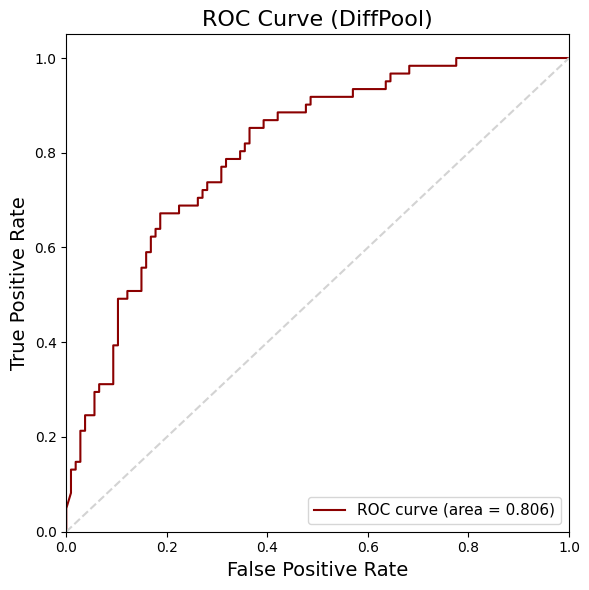

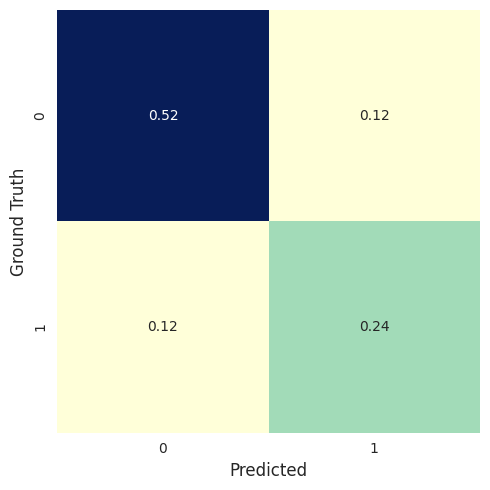

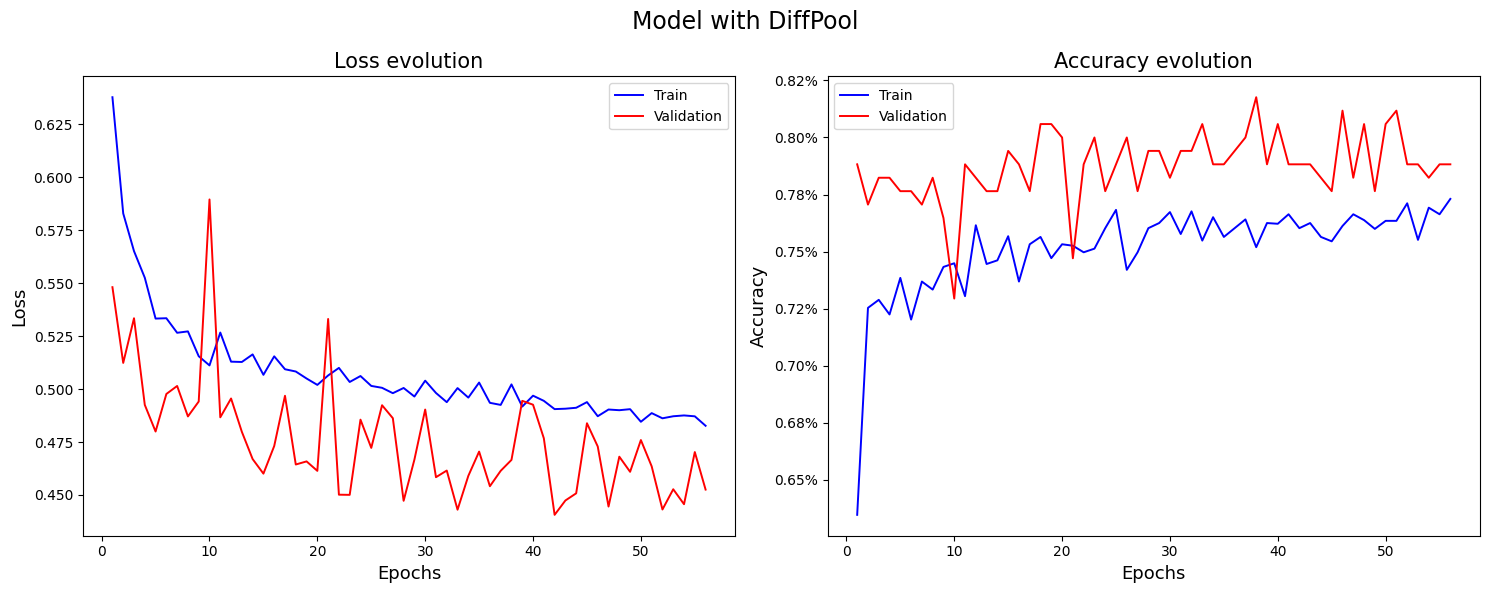

In [ ]:

# Test

# For storing

name_vis = "Model with DiffPool"
name_save = "diff_pool"


# Reloading best model
best_model = early_stopper_diff.best_model.to(device)


# Evaluation
diff_test_loss, diff_test_acc, diff_confusion_matrix = test_dense(model, loss_fcn, test_loader, device, cm=True, title="DiffPool", c="darkred",  path=PATH_IMG, name_save=name_save + "_roc")



# Plots
history_diff = [[diff_tr_loss, diff_val_loss], [diff_tr_acc, diff_val_acc]]


plot_confusion_matrix(diff_confusion_matrix, PATH_IMG, name_save=name_save + "_cm")

plot_results(history_diff, name_vis, yticks, PATH_IMG, name_save=name_save + "_results")






## Torch Loading (not dense)

In [ ]:


# Fix seed
set_reproducible()


dataset = torch_geometric.datasets.TUDataset(root=f'./data', name='PROTEINS', transform=AddSelfLoops())



# Get Loaders
train_batch_size, val_batch_size, test_batch_size = 5, 5, 1


train_loader, val_loader, test_loader = get_torch_loaders(dataset, TRAIN_RATIO, VAL_RATIO, train_batch_size, val_batch_size, test_batch_size, generator, dense=False)





Length training set 779, Length validation set 166, Length test set 168


# SAGPool

In [ ]:


from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn.pool import SAGPooling
from torch_geometric.nn.pool.topk_pool import topk,filter_adj
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F



class SAGNet(torch.nn.Module):
    """
    Model exploiting Self Attention Pooling layers, based on a top-k selection for each example
    """
    def __init__(self,args):
        super(SAGNet, self).__init__()
        self.args = args
        self.num_features = args.num_features
        self.nhid = args.nhid
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout_ratio
        
        self.conv1 = GCNConv(self.num_features, self.nhid)
        self.pool1 = SAGPooling(self.nhid, ratio=self.pooling_ratio, GNN=GCNConv)
        self.conv2 = GCNConv(self.nhid, self.nhid)
        self.pool2 = SAGPooling(self.nhid, ratio=self.pooling_ratio, GNN=GCNConv)
        self.conv3 = GCNConv(self.nhid, self.nhid)
        self.pool3 = SAGPooling(self.nhid, ratio=self.pooling_ratio, GNN=GCNConv)

        self.lin1 = torch.nn.Linear(self.nhid*2, self.nhid)
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid//2)
        self.lin3 = torch.nn.Linear(self.nhid//2, self.num_classes)


    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _= self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x



In [ ]:


num_node_features = dataset.num_node_features
num_classes = dataset.num_classes


args = Args(
    num_features=num_node_features,
    nhid=128,
    num_classes=num_classes,
    pooling_ratio= 0.5,
    dropout_ratio= 0.5
)



model = SAGNet(args).to(device)

num_epochs = 200
wd = 0.01
lr = 2e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True, weight_decay = wd)


criterion = torch.nn.NLLLoss()


patience, delta = 20, 0
early_stopper_sagpool = EarlyStopping(patience, delta, path=PATH_MODELS)



# Train and Valid

sagpool_tr_loss, sagpool_tr_acc, sagpool_val_loss, sagpool_val_acc = train_torch(model, criterion, optim, train_loader, val_loader, num_epochs, 
                                                               early_stopper_sagpool, device, save="model_sag_pool", scheduler=None)
 

Epoch 0/200 | Train Loss: 0.6766 | Train Accuracy: 59.5833% | Val Loss: 0.6722 | Val Accuracy 60.0000%
Epoch 10/200 | Train Loss: 0.5479 | Train Accuracy: 72.8205% | Val Loss: 0.5056 | Val Accuracy 75.2941%
Epoch 20/200 | Train Loss: 0.5443 | Train Accuracy: 72.0192% | Val Loss: 0.5063 | Val Accuracy 75.2941%
Epoch 30/200 | Train Loss: 0.5314 | Train Accuracy: 73.9103% | Val Loss: 0.5140 | Val Accuracy 75.8824%
Epoch 40/200 | Train Loss: 0.5192 | Train Accuracy: 74.4872% | Val Loss: 0.5159 | Val Accuracy 76.4706%
Epoch 50/200 | Train Loss: 0.5229 | Train Accuracy: 74.1987% | Val Loss: 0.5111 | Val Accuracy 76.4706%
Early Stopping!



Test Loss: 0.6056 | F1 score: 0.6569 | Test Accuracy 72.0238%



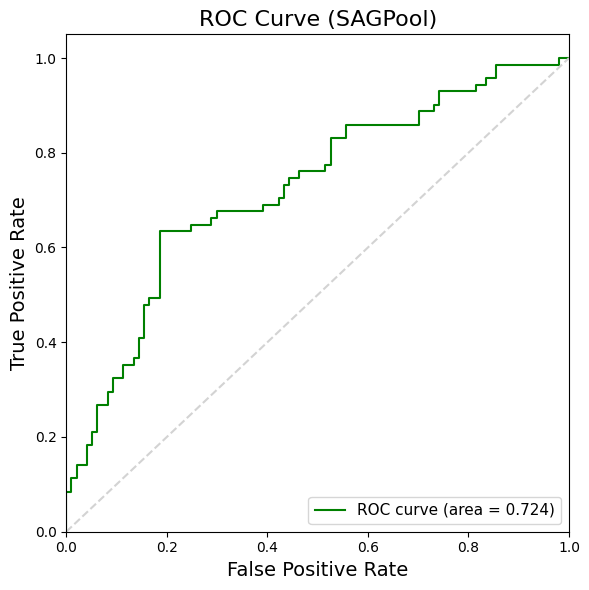

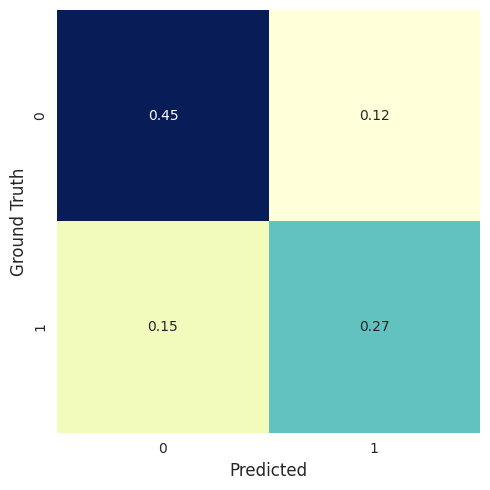

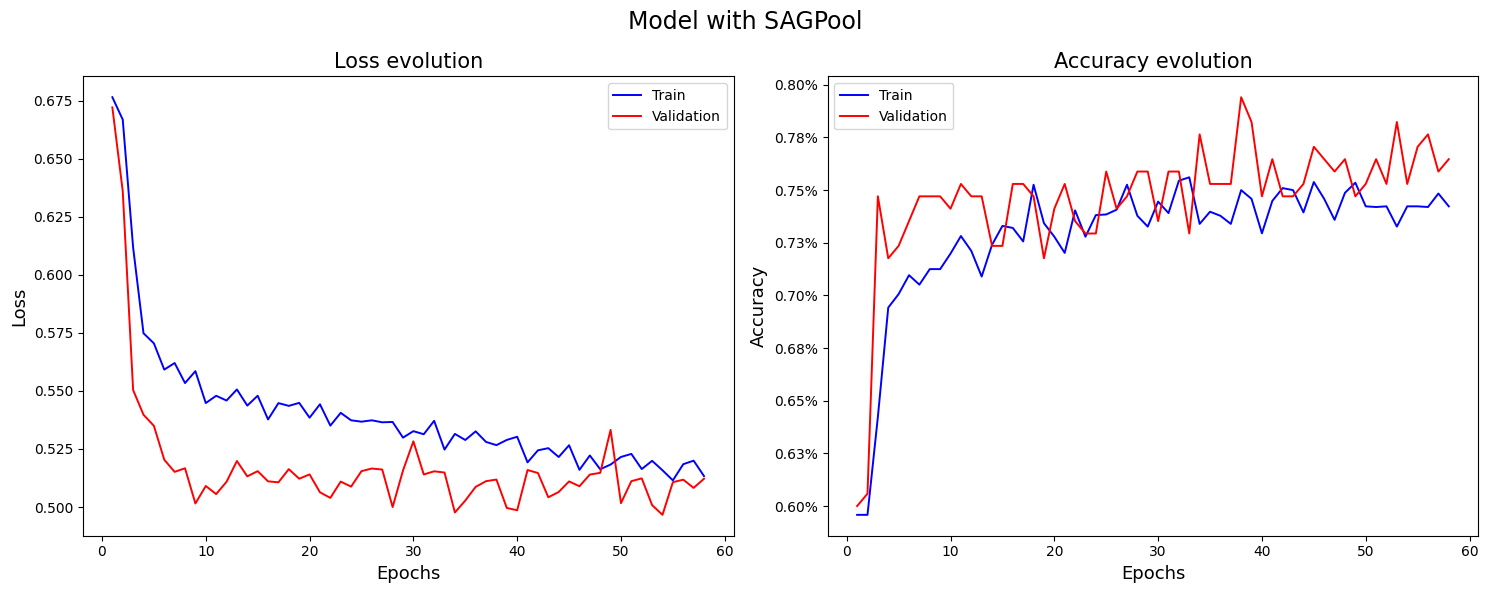

In [ ]:

# Test

# For storing
name_vis = "Model with SAGPool"
name_save = "sag_pool"


# Reloading best model
best_model = early_stopper_sagpool.best_model.to(device)


# Evaluation
sagpool_test_loss, sagpool_test_acc, sagpool_confusion_matrix = test_torch(best_model, loss_fcn, test_loader, device, cm=True, title="SAGPool", 
                                                                           c="green",  path=PATH_IMG, name_save=name_save + "_roc")



# Plots
history_sagpool = [[sagpool_tr_loss, sagpool_val_loss], [sagpool_tr_acc, sagpool_val_acc]]

plot_confusion_matrix(sagpool_confusion_matrix, PATH_IMG, name_save=name_save + "_cm")

plot_results(history_sagpool, name_vis, yticks, PATH_IMG, name_save=name_save + "_results")



## HGPSL Pool

In [ ]:


from torch_geometric.nn import GCNConv
from models import GCN, HGPSLPool


class HGPSL_Model(torch.nn.Module):
    """
    Model based on the SOTA technique of Hierarchical Graph Pooling with Structure Learning
    """
    def __init__(self, args):
        super(HGPSL_Model, self).__init__()
        self.args = args
        self.num_features = args.num_features
        self.nhid = args.nhid
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout_ratio
        self.sample = args.sample_neighbor
        self.sparse = args.sparse_attention
        self.sl = args.structure_learning
        self.lamb = args.lamb

        self.conv1 = GCNConv(self.num_features, self.nhid)
        self.conv2 = GCN(self.nhid, self.nhid)
        self.conv3 = GCN(self.nhid, self.nhid)

        self.pool1 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)
        self.pool2 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)

        self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid // 2)
        self.lin3 = torch.nn.Linear(self.nhid // 2, self.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

        

In [ ]:

num_node_features = dataset.num_node_features
num_classes = dataset.num_classes



args = Args(
    num_features=num_node_features,
    nhid=64,
    num_classes=num_classes,
    pooling_ratio=0.5,
    dropout_ratio=0.5,
    sample_neighbor=False,
    sparse_attention=False,
    structure_learning=False,
    lamb=1.0
)



model = HGPSL_Model(args).to(device)

num_epochs = 200
wd = 0.01
lr = 2e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True, weight_decay = wd)


criterion = torch.nn.NLLLoss()


patience, delta = 20, 0
early_stopper_hgpsl = EarlyStopping(patience, delta, path=PATH_MODELS)



# Train and Valid

hgpsl_tr_loss, hgpsl_tr_acc, hgpsl_val_loss, hgpsl_val_acc = train_torch(model, criterion, optim, train_loader, val_loader, num_epochs, 
                                                               early_stopper_hgpsl, device, save="model_hgpsl_pool", scheduler=None)




Epoch 0/200 | Train Loss: 0.6900 | Train Accuracy: 54.2628% | Val Loss: 0.6775 | Val Accuracy 64.1176%
Epoch 10/200 | Train Loss: 0.5673 | Train Accuracy: 71.7628% | Val Loss: 0.5594 | Val Accuracy 71.1765%
Epoch 20/200 | Train Loss: 0.5594 | Train Accuracy: 73.0449% | Val Loss: 0.5581 | Val Accuracy 72.3529%
Epoch 30/200 | Train Loss: 0.5564 | Train Accuracy: 73.0769% | Val Loss: 0.5525 | Val Accuracy 71.7647%
Epoch 40/200 | Train Loss: 0.5510 | Train Accuracy: 73.0769% | Val Loss: 0.5780 | Val Accuracy 71.1765%
Early Stopping!



Test Loss: 0.5026 | F1 score: 0.7059 | Test Accuracy 79.1667%



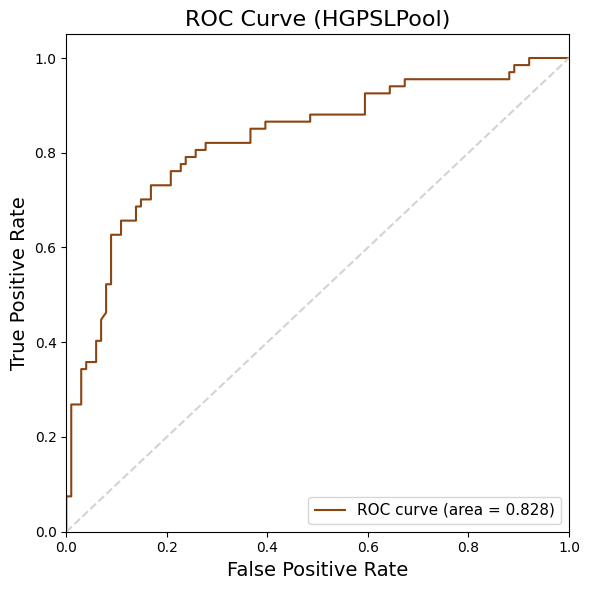

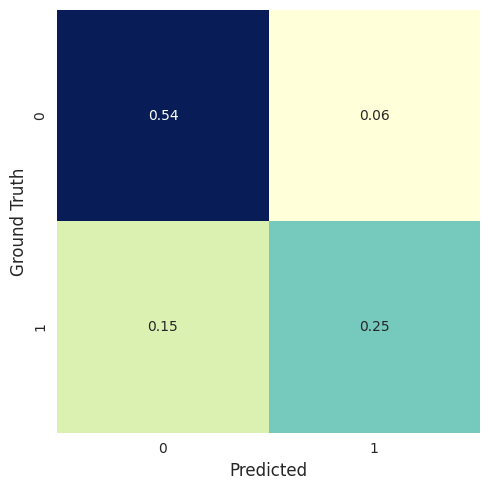

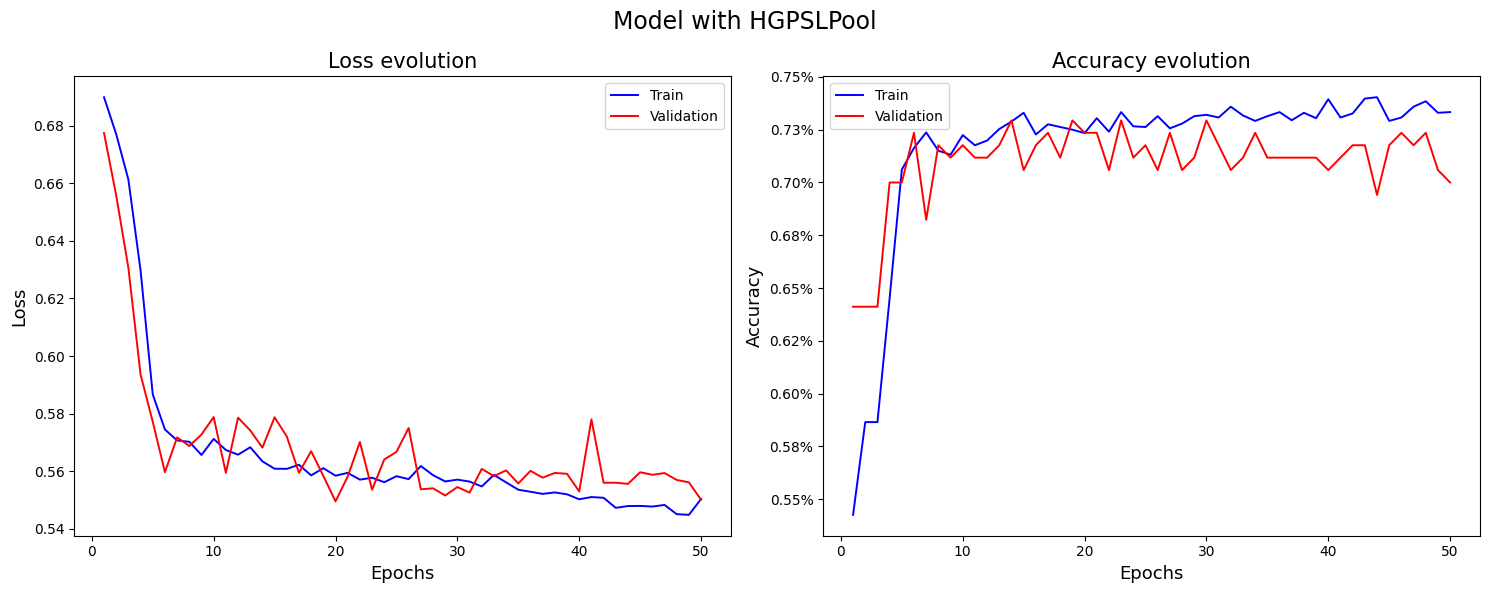

In [ ]:

# Test

# For storing

name_vis = "Model with HGPSLPool"
name_save = "hgpsl_pool"

# Reloading best model
best_model = early_stopper_hgpsl.best_model.to(device)

# Evaluation
hgpsl_test_loss, hgpsl_test_acc, hgpsl_confusion_matrix = test_torch(best_model, loss_fcn, test_loader, device, cm=True, title="HGPSLPool",
                                                                     c="saddlebrown",  path=PATH_IMG, name_save=name_save + "_roc")



# Plots
history_hgpsl = [[hgpsl_tr_loss, hgpsl_val_loss], [hgpsl_tr_acc, hgpsl_val_acc]]


plot_confusion_matrix(hgpsl_confusion_matrix, PATH_IMG, name_save=name_save + "_cm")

plot_results(history_hgpsl, name_vis, yticks, PATH_IMG, name_save=name_save  + "_results")



